In [3]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 6.7 kB/s 
     |████████████████████████████████| 439 kB 38.6 MB/s 
     |████████████████████████████████| 6.0 MB 35.8 MB/s 
     |████████████████████████████████| 1.7 MB 27.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully 

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
!pip install import_ipynb
import import_ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.2 MB/s 


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-small

 98% 554M/565M [00:04<00:00, 151MB/s]
100% 565M/565M [00:04<00:00, 130MB/s]


In [8]:
import zipfile
zip_ref = zipfile.ZipFile("/content/fashion-product-images-small.zip", "r")
zip_ref.extractall("/content")
zip_ref.close()

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet import ResNet50,preprocess_input
import keras.backend as K
from keras.layers import GlobalMaxPooling2D,Dense,Flatten
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import math

In [11]:
from utils import *
from dataset import train_val_split,FashionDataset

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from dataset.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
#Loading the labels and removing missing images:
data=pd.read_csv('/content/styles.csv',usecols=["id","gender","masterCategory",
                                                 "subCategory","articleType",
                                                 "baseColour","season","usage"])

In [13]:
# training and validation dataset
dataset = FashionDataset(data,labels=["gender","masterCategory","subCategory"])

[INFO]: Checking if all images are present


44446it [00:03, 13255.34it/s]


[INFO]: Dropping indices: [6697, 16207, 32324, 36399, 40022]


In [14]:
dataset.df.head()

,id,classes
0,15970.jpg,"(Men, Apparel, Topwear)"
1,39386.jpg,"(Men, Apparel, Bottomwear)"
2,59263.jpg,"(Women, Accessories, Watches)"
3,21379.jpg,"(Men, Apparel, Bottomwear)"
4,53759.jpg,"(Men, Apparel, Topwear)"


In [15]:
train_data, val_data = train_val_split(dataset.df)
print(f"[INFO]: Number of training sampels: {len(train_data)}")
print(f"[INFO]: Number of validation sampels: {len(val_data)}")

[INFO]: Number of training sampels: 39996
[INFO]: Number of validation sampels: 4444


In [16]:
batch_size_ = 128
image_size = 224

In [17]:
def multi (generator,mlb_,image_df):
  for x,y in generator:
      indices = y.astype(np.int32).tolist()
      y_multi = mlb_.transform(image_df.iloc[indices]['classes'].values.tolist())
      yield x, y_multi

In [18]:
# training and validation data loader
train_generator = dataset.datagen_transfer.flow_from_dataframe(
    train_data, 
    batch_size=batch_size_,
    directory='./images/',
    x_col='id',
    y_col='index',
    class_mode='other',
    target_size=(image_size, image_size),
    shuffle=True
)
val_generator = dataset.datagen_transfer.flow_from_dataframe(
    val_data, 
    batch_size=batch_size_,
    directory='./images/',
    x_col='id',
    y_col='index',
    class_mode='other',
    target_size=(image_size, image_size),
    shuffle=True
)

Found 39996 validated image filenames.
Found 4444 validated image filenames.


In [19]:
from sklearn.preprocessing import MultiLabelBinarizer
# Fit a MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(dataset.df['classes'].values.tolist())

MultiLabelBinarizer()

In [20]:
len(mlb.classes_)

56

In [21]:
train_multilabel_generator = multi(train_generator, mlb, train_data)
val_multilabel_generator = multi(val_generator, mlb, val_data)

In [22]:
num_classes = len(mlb.classes_)

In [23]:
conv_base = ResNet50(weights="imagenet",include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 1s 0us/step


In [25]:
model = Sequential()

In [26]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPooling2D
model.add(conv_base)
model.add(GlobalMaxPooling2D())
model.add(Dense(num_classes,activation="sigmoid",name="fc"+str(num_classes)))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 fc56 (Dense)                (None, 56)                114744    
                                                                 
Total params: 23,702,456
Trainable params: 23,649,336
Non-trainable params: 53,120
_________________________________________________________________


In [29]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == "conv5_block1_1_conv":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
      layer.trainable = False

In [33]:
lr = 0.001
optim = tf.keras.optimizers.RMSprop(learning_rate=lr)
epochs = 1
step_train = math.ceil(train_data.shape[0]/batch_size_)
step_val = math.ceil(val_data.shape[0]/batch_size_)
loss_func = "binary_crossentropy"

In [35]:
model.compile(optimizer=optim,loss = loss_func,metrics=["binary_accuracy"])

In [38]:
# checkpoint
file_dir = "/content/drive/MyDrive/capstone project"
file_name="weights_best.hdf5"
filepath = os.path.join(file_dir,file_name)
checkpoint = ModelCheckpoint(filepath, monitor='binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [39]:
history = model.fit_generator(
    train_multilabel_generator,
    epochs=epochs,
    validation_data=val_multilabel_generator,
    callbacks=callbacks_list,
    steps_per_epoch=step_train,
    validation_steps=step_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


313/313 [==============================] - ETA: 0s - loss: 0.0681 - binary_accuracy: 0.9840 

313/313 [==============================] - 12375s 40s/step - loss: 0.0681 - binary_accuracy: 0.9840 - val_loss: 0.0302 - val_binary_accuracy: 0.9899


In [43]:
save_model_arc(model)

In [44]:
save_model_wts(model)

In [41]:
import matplotlib.pyplot as plt

In [46]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

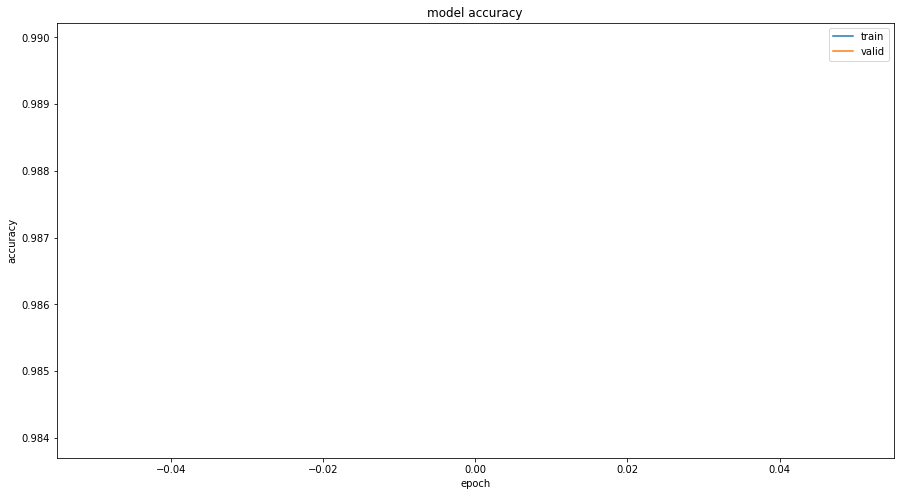

In [48]:
plt.figure(1, figsize = (15,8)) 
    
#plt.subplot(221)  
plt.plot(history.history['binary_accuracy'])  
plt.plot(history.history['val_binary_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()